In [5]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_palette('colorblind'); sns.set_color_codes()

#### Code 7.1

In [6]:
d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
#d.head()

# make log version of outcome
d.log_gdp = np.log(d.rgdppc_2000)

# extract countries with GDP data
dd = d[np.isfinite(d['rgdppc_2000'])]

# split countries into Africa and non-Africa
d.A1 = dd[dd.cont_africa==1]  # Africa
d.A0 = dd[dd.cont_africa==0]  # not Africa

#### Code 7.2

In [7]:
# Fit the regression models with this code.
# African nations
with pm.Model() as model_7_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A1['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A1['rgdppc_2000']))
    trace_7_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -77.023: 100%|██████████| 200000/200000 [00:15<00:00, 13200.89it/s]
Finished [100%]: Average ELBO = -77.02
100%|██████████| 1000/1000 [00:01<00:00, 548.69it/s]


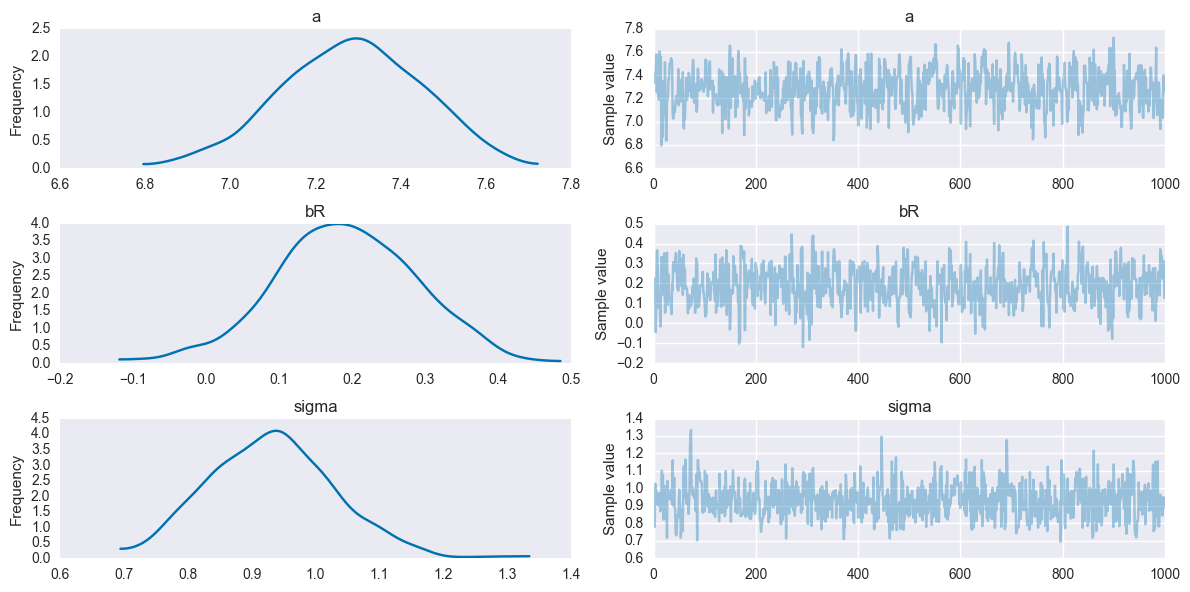

In [8]:
varnames = ['a', 'bR', 'sigma']
pm.traceplot(trace_7_2, varnames);

In [9]:
# non-African nations
with pm.Model() as model_7_2_2:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # good (default) alternatives for sigma (in this and other models) are
    # sigma = pm.HalfNormal('sigma', 5)
    # sigma = pm.HalfCauchy('sigma', 5)
    # some people recomed avoiding "hard" boundaries unless they have a theoretical/data-based justification, like a correlation that is restricted to be [-1, 1].
    mu = pm.Deterministic('mu', a + bR * d.A0['rugged'])
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(d.A0['rgdppc_2000']))
    trace_7_2_2 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -179.57: 100%|██████████| 200000/200000 [00:14<00:00, 14007.67it/s]
Finished [100%]: Average ELBO = -179.54
100%|██████████| 1000/1000 [00:02<00:00, 472.30it/s]


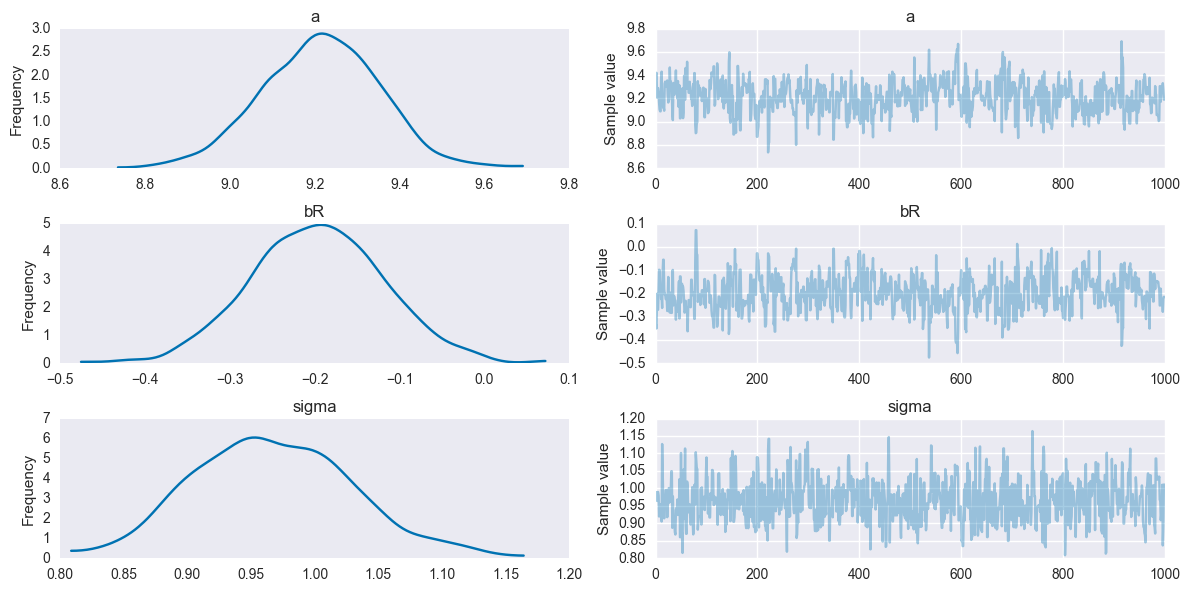

In [10]:
pm.traceplot(trace_7_2_2, varnames);

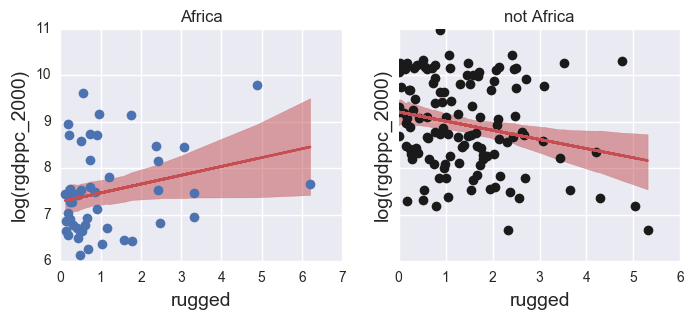

In [11]:
# Plot the data

mu_mean = trace_7_2['mu']
mu_hpd = pm.hpd(mu_mean)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
ax1.plot(d.A1['rugged'], mu_mean.mean(0), 'r')
idx = np.argsort(d.A1['rugged'])
# I used .sort_values() as it does a better job at sorting them as opposed to indexing a sorted list.
ax1.fill_between(d.A1['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)
ax1.set_title('Africa')
ax1.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax1.set_xlabel('rugged', fontsize=14)

mu_mean = trace_7_2_2['mu']
mu_hpd = pm.hpd(mu_mean)

ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(d.A0['rugged'], mu_mean.mean(0), 'r')
ax2.set_title('not Africa')
ax2.set_ylabel('log(rgdppc_2000)', fontsize=14);
ax2.set_xlabel('rugged', fontsize=14)
idx = np.argsort(d.A0['rugged'])
ax2.fill_between(d.A0['rugged'].sort_values(), mu_hpd[:,0][idx], mu_hpd[:,1][idx], color='r', alpha=0.5)
plt.show()

#### Code 7.3

In [12]:
# Model the entire data
with pm.Model() as model_7_3:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_3 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -281.09: 100%|██████████| 200000/200000 [00:15<00:00, 13325.27it/s]
Finished [100%]: Average ELBO = -281.08
100%|██████████| 1000/1000 [00:01<00:00, 766.06it/s]


#### Code 7.4

In [13]:
# Model the entire data including a dummy variable
with pm.Model() as model_7_4:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_4 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -251.63: 100%|██████████| 200000/200000 [00:15<00:00, 12788.77it/s]
Finished [100%]: Average ELBO = -251.61
100%|██████████| 1000/1000 [00:02<00:00, 384.64it/s]


#### Code 7.5

In [14]:
def compare_waic(mod1, trace1, mod2, trace2):
    '''Compare fitted models using widely applicable information criterion.'''
    waic1 = pm.stats.waic(model=mod1, trace=trace1, pointwise=True)
    waic2 = pm.stats.waic(model=mod2, trace=trace2, pointwise=True)
    
    # Calculate diff in expected predictive accuracy
    diff = waic2[2] - waic1[2]
    d_waic = np.sum(diff)
    d_se = np.sqrt(len(diff)) * np.var(diff)
    
    print("\tWAIC \tpWAIC \tdWAIC \tSE \tdSE")     
    print("mod1  \t%.1f \t%.1f \t%.1f \t%.1f \t%.1f" %(waic1[0], waic1[3], np.abs(d_waic), waic1[1], d_se))
    print("mod2  \t%.1f \t%.1f \t%.1f \t%.1f \t%.1f" %(waic2[0], waic2[3], np.abs(d_waic), waic2[1], d_se))

In [15]:
compare_waic(model_7_3, trace_7_3, model_7_4, trace_7_4)

	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	538.8 	2.2 	62.9 	12.9 	16.2
mod2  	475.9 	4.0 	62.9 	14.7 	16.2


/home/raid2/mihai/.local/lib/python2.7/site-packages/pymc3/stats.py:146: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


#### Code 7.6

Since the link function isn't implemented we have to compute the mean over samples ourselves using a loop.

In [16]:
rugged_seq = np.arange(-1, 9, 0.35)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_4)))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_4)))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_4['a'] + trace_7_4['bR'] * rugged_seq[iSeq] + trace_7_4['bA'] * 1

In [17]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

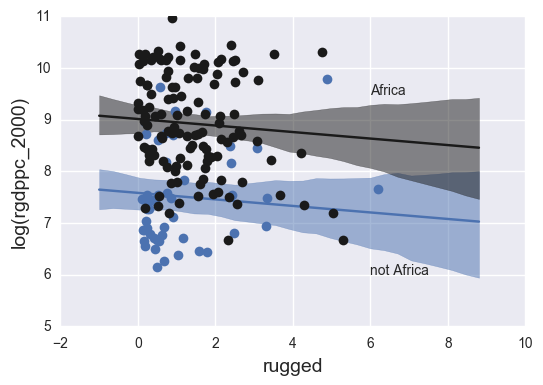

In [18]:
plt.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
plt.plot(rugged_seq, mu_mean_Africa, 'b')
plt.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='b', alpha=0.5)
plt.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
plt.plot(rugged_seq, mu_mean_NotAfrica, 'k')
plt.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
plt.annotate('Africa', xy=(6, 9.5))
plt.annotate('not Africa', xy=(6, 6))
plt.ylabel('log(rgdppc_2000)', fontsize=14);
plt.xlabel('rugged', fontsize=14)
plt.show()

#### Code 7.7

In [19]:
with pm.Model() as model_7_5:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    gamma = bR + bAR * dd.cont_africa
    mu = pm.Deterministic('mu', a + gamma * dd.rugged + bA * dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -250.66: 100%|██████████| 200000/200000 [00:18<00:00, 10802.61it/s]
Finished [100%]: Average ELBO = -250.63
100%|██████████| 1000/1000 [00:03<00:00, 267.04it/s]


#### Code 7.8

In [20]:
compare_waic(model_7_4, trace_7_4, model_7_5, trace_7_5)

	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	475.9 	4.0 	6.6 	14.7 	2.8
mod2  	469.2 	5.0 	6.6 	14.6 	2.8


In [21]:
compare_waic(model_7_3, trace_7_3, model_7_5, trace_7_5)

	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	538.8 	2.2 	69.5 	12.9 	16.6
mod2  	469.2 	5.0 	69.5 	14.6 	16.6


#### Code 7.9

In [22]:
with pm.Model() as model_7_5b:
    a = pm.Normal('a', mu=8, sd=100)
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    bAR = pm.Normal('bAR', mu=0, sd=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + bR*dd.rugged + bAR*dd.rugged*dd.cont_africa + bA*dd.cont_africa)
    log_gdp = pm.Normal('log_gdp', mu, sigma, observed=np.log(dd.rgdppc_2000))
    trace_7_5b = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -250.68: 100%|██████████| 200000/200000 [00:17<00:00, 11663.54it/s]
Finished [100%]: Average ELBO = -250.66
100%|██████████| 1000/1000 [00:03<00:00, 312.45it/s]


#### Code 7.10
First calculate the necessary posterior predicted means. The link function is replaced by a loop. We'll use model 7.5b since it's a one-liner.


In [23]:
rugged_seq = np.arange(-1, 9, 0.25)

# compute mu over samples
mu_pred_NotAfrica = np.zeros((len(rugged_seq), len(trace_7_5b)))
mu_pred_Africa = np.zeros((len(rugged_seq), len(trace_7_5b)))
for iSeq, seq in enumerate(rugged_seq):
    mu_pred_NotAfrica[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*0 +\
                              trace_7_5b['bA'] * 0
    mu_pred_Africa[iSeq] = trace_7_5b['a'] + trace_7_5b['bR']*rugged_seq[iSeq] + \
                              trace_7_5b['bAR']*rugged_seq[iSeq]*1 +\
                              trace_7_5b['bA'] * 1

In [24]:
# summarize to means and intervals
mu_mean_NotAfrica = mu_pred_NotAfrica.mean(1)
mu_hpd_NotAfrica = pm.hpd(mu_pred_NotAfrica.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_mean_Africa = mu_pred_Africa.mean(1)
mu_hpd_Africa = pm.hpd(mu_pred_Africa.T, alpha=0.03)

#### Code 7.11

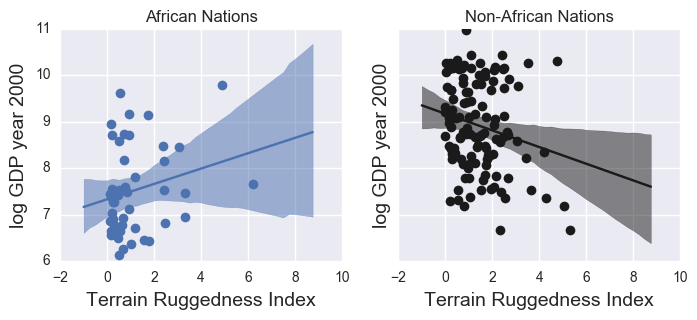

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,3))
ax1.plot(d.A1['rugged'], np.log(d.A1['rgdppc_2000']), 'bo')
ax1.plot(rugged_seq, mu_mean_Africa, 'b')
ax1.fill_between(rugged_seq, mu_hpd_Africa[:,0], mu_hpd_Africa[:,1], color='b', alpha=0.5)
ax1.set_title('African Nations')
ax1.set_ylabel('log GDP year 2000', fontsize=14);
ax1.set_xlabel('Terrain Ruggedness Index', fontsize=14)
               
ax2.plot(d.A0['rugged'], np.log(d.A0['rgdppc_2000']), 'ko')
ax2.plot(rugged_seq, mu_mean_NotAfrica, 'k')
ax2.fill_between(rugged_seq, mu_hpd_NotAfrica[:,0], mu_hpd_NotAfrica[:,1], color='k', alpha=0.5)
ax2.set_title('Non-African Nations')
ax2.set_ylabel('log GDP year 2000', fontsize=14)
ax2.set_xlabel('Terrain Ruggedness Index', fontsize=14)
plt.show()

#### Code 7.12

In [26]:
varnames = ['a', 'bA', 'bR', 'bAR', 'sigma']
vars = pm.df_summary(trace_7_5b, varnames)
print vars

           mean        sd  mc_error   hpd_2.5  hpd_97.5
a      9.174850  0.141525  0.008657  8.918596  9.459426
bA    -1.840192  0.226780  0.013386 -2.300117 -1.428722
bR    -0.179313  0.076831  0.004607 -0.318840 -0.024261
bAR    0.344371  0.130365  0.007569  0.090529  0.599286
sigma  0.949941  0.055642  0.001933  0.848838  1.064368


The MAP slope relating ruggedness to log-GDP within Africa is:

In [27]:
gamma_Africa = vars['mean']['bR'] + vars['mean']['bAR'] * 1
gamma_notAfrica = vars['mean']['bR'] + vars['mean']['bAR'] * 0
print("Gamma within Africa: %.2f" %gamma_Africa)
print("Gamma outside Africa: %.2f" %gamma_notAfrica)

Gamma within Africa: 0.17
Gamma outside Africa: -0.18


#### Code 7.13

In [28]:
post = pm.trace_to_dataframe(trace_7_5b)
gamma_Africa = post.bR + post.bAR * 1
gamma_notAfrica = post.bR + post.bAR * 0

#### Code 7.14

In [29]:
print np.mean(gamma_Africa)
print np.mean(gamma_notAfrica)

0.165058700047
-0.179312772016


#### Code 7.15

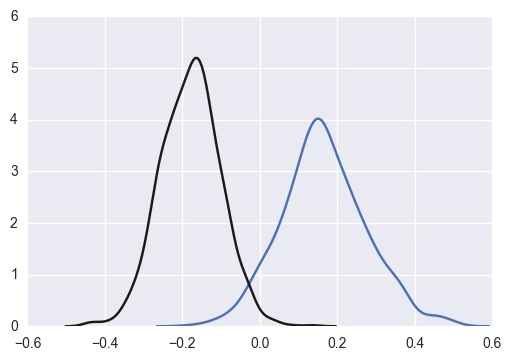

In [30]:
sns.kdeplot(gamma_Africa, color='b')
sns.kdeplot(gamma_notAfrica, color='k')
plt.show()

#### Code 7.16

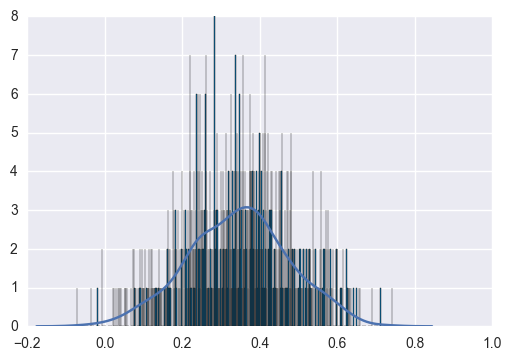

In [31]:
diff = gamma_Africa - gamma_notAfrica
# First let's plot a histogram and a kernel densitiy estimate.
sns.kdeplot(diff, color='b')
hist, bins = np.histogram(diff, bins=1000)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()
# Notice that there are very few values below zero.

Hence the probability to have a negative slope association ruggedness with log-GDP inside Africa is so small, it might just be zero.

In [32]:
sum(diff[diff<0]) / float(len(diff))

-0.00014315607171754005

#### Code 7.17
Plot the reverse interpretation: The influence of being in Africa depends upon terrain ruggedness.

This places `cont_africa` on the horizontal axis, while using different lines for different values of `rugged`.

In [33]:
# Get min and max rugged values.
q_rugged = [0, 0]
q_rugged[0] = np.min(dd.rugged)
q_rugged[1] = np.max(dd.rugged)

In [35]:
# Compute lines and confidence intervals.
# Since the link function isn't implemented we have to again compute the mean over samples ourselves using a loop.
mu_ruggedlo = np.zeros((2, len(trace_7_5b)))
mu_ruggedhi = np.zeros((2, len(trace_7_5b)))
# Iterate over outside Africa (0) and inside Africa (1).
for iAfri in range(0,2):
    mu_ruggedlo[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[0] + \
                              trace_7_5b['bAR'] * q_rugged[0] * iAfri + \
                              trace_7_5b['bA'] * iAfri
    mu_ruggedhi[iAfri] = trace_7_5b['a'] + trace_7_5b['bR'] * q_rugged[1] + \
                              trace_7_5b['bAR'] * q_rugged[1] * iAfri + \
                              trace_7_5b['bA'] * iAfri

In [36]:
mu_ruggedlo_mean = np.mean(mu_ruggedlo, axis=1)
mu_hpd_ruggedlo = pm.hpd(mu_ruggedlo.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03
mu_ruggedhi_mean = np.mean(mu_ruggedhi, axis=1)
mu_hpd_ruggedhi = pm.hpd(mu_ruggedhi.T, alpha=0.03)  # 97% probability interval: 1-.97 = 0.03

In [37]:
# Source http://matplotlib.org/examples/pylab_examples/spine_placement_demo.html
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

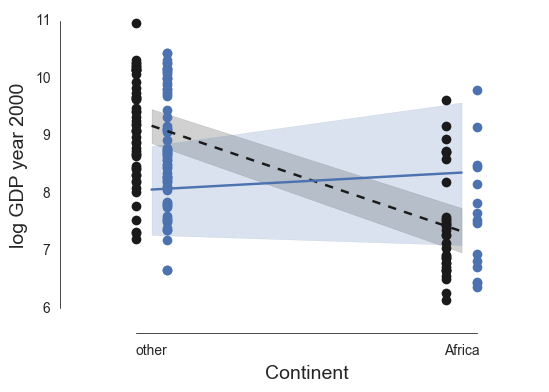

In [38]:
# Plot it all, splitting points at median
med_r = np.median(dd.rugged)
# Use list comprehension to split points at median
ox = [0.05 if x > med_r else -0.05 for x in dd.rugged]
idxk = [i for i,x in enumerate(ox) if x == -0.05]
idxb = [i for i,x in enumerate(ox) if x == 0.05]
cont_africa_ox = dd.cont_africa + ox
plt.plot(cont_africa_ox[dd.cont_africa.index[idxk]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxk]]), 'ok')
plt.plot(cont_africa_ox[dd.cont_africa.index[idxb]], np.log(dd.rgdppc_2000[dd.cont_africa.index[idxb]]), 'ob')
plt.plot([0, 1], mu_ruggedlo_mean, '--k')
plt.plot([0, 1], mu_ruggedhi_mean, 'b')
plt.fill_between([0, 1], mu_hpd_ruggedlo[:,0], mu_hpd_ruggedlo[:,1], color='k', alpha=0.2)
plt.fill_between([0, 1], mu_hpd_ruggedhi[:,0], mu_hpd_ruggedhi[:,1], color='b', alpha=0.2)
plt.ylabel('log GDP year 2000', fontsize=14);
plt.xlabel('Continent', fontsize=14)
axes = plt.gca()
axes.set_xlim([-0.25, 1.25])
axes.set_ylim([5.8, 11.2])
axes.set_xticks([0, 1])
axes.set_xticklabels(['other', 'Africa'], fontsize=12)
axes.set_axis_bgcolor('white')
adjust_spines(axes, ['left', 'bottom'])
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.spines['bottom'].set_linewidth(0.5)
axes.spines['left'].set_linewidth(0.5)
axes.spines['bottom'].set_color('black')
axes.spines['left'].set_color('black')
plt.show()


#### Code 7.16

In [42]:
d = pd.read_csv('Data/tulips.csv', sep=';', header=0)
d.info()
d.head()
d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 4 columns):
bed       27 non-null object
water     27 non-null int64
shade     27 non-null int64
blooms    27 non-null float64
dtypes: float64(1), int64(2), object(1)
memory usage: 936.0+ bytes


,water,shade,blooms
count,27.00000,27.00000,27.000000
mean,2.00000,2.00000,128.993704
std,0.83205,0.83205,92.683923
min,1.00000,1.00000,0.000000
25%,1.00000,1.00000,71.115000
50%,2.00000,2.00000,111.040000
75%,3.00000,3.00000,190.300000
max,3.00000,3.00000,361.660000


#### Code 7.19

In [45]:
with pm.Model() as model_7_6:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_6 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -165.13: 100%|██████████| 200000/200000 [00:15<00:00, 12993.62it/s]
Finished [100%]: Average ELBO = -164.55
100%|██████████| 1000/1000 [00:05<00:00, 168.85it/s]


In [46]:
with pm.Model() as model_7_7:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water + bS*d.shade + bWS*d.water*d.shade)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_7 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -169.4: 100%|██████████| 200000/200000 [00:17<00:00, 11634.53it/s]
Finished [100%]: Average ELBO = -168.76
100%|██████████| 1000/1000 [00:11<00:00, 86.47it/s]


In [58]:
map_7_6 = pm.find_MAP(model=model_7_6)
print(map_7_6)

Optimization terminated successfully.
         Current function value: 166.145654
         Iterations: 43
         Function evaluations: 47
         Gradient evaluations: 47
{'a': array(53.55788897623509), 'bW': array(76.357601249545), 'sigma_interval_': array(0.28345355624047636), 'bS': array(-38.96237241859207)}


In [59]:
map_7_7 = pm.find_MAP(model=model_7_7)
print(map_7_7)

Optimization terminated successfully.
         Current function value: 166.956074
         Iterations: 48
         Function evaluations: 51
         Gradient evaluations: 51
{'a': array(-84.08262335537444), 'bWS': array(-39.45644221156182), 'bW': array(150.9020313961203), 'sigma_interval_': array(-0.1451842845396202), 'bS': array(34.88391364061515)}


#### Code 7.20
You can use the modified Powell's method if it fails with BFGS (default MAP estimate)

In [70]:
from scipy import optimize
map_7_6 = pm.find_MAP(model=model_7_6, fmin=optimize.fmin_powell)
print(map_7_6)

Optimization terminated successfully.
         Current function value: 166.145656
         Iterations: 11
         Function evaluations: 524
{'a': array(53.56673498649855), 'bW': array(76.33962477177363), 'sigma_interval_': array(0.28335687752938676), 'bS': array(-38.9455752393687)}


In [71]:
map_7_7 = pm.find_MAP(model=model_7_7, fmin=optimize.fmin_powell)
print(map_7_7)

Optimization terminated successfully.
         Current function value: 166.956958
         Iterations: 14
         Function evaluations: 790
{'a': array(-83.27436922390079), 'bWS': array(-39.3245876127497), 'bW': array(150.65437787401956), 'sigma_interval_': array(-0.15155943732982818), 'bS': array(34.586330600000025)}


#### Code 7.21
`conftab` not implemented

#### Code 7.22

In [72]:
compare_waic(model_7_6, trace_7_6, model_7_7, trace_7_7)

	WAIC 	pWAIC 	dWAIC 	SE 	dSE
mod1  	304.0 	3.8 	9.4 	6.9 	3.2
mod2  	294.6 	4.4 	9.4 	7.3 	3.2


#### 7.23
Center and re-estimate

In [76]:
d.shade_c = d.shade - np.mean(d.shade)
d.water_c = d.water - np.mean(d.water)

#### 7.24

In [83]:
with pm.Model() as model_7_8:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    #bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bW*d.water_c + bS*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_8 = pm.sample(1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -171.53: 100%|██████████| 200000/200000 [00:15<00:00, 13287.42it/s]
Finished [100%]: Average ELBO = -169.97
100%|██████████| 1000/1000 [00:02<00:00, 366.10it/s]


In [84]:
with pm.Model() as model_7_9:
    a = pm.Normal('a', mu=0, sd=100)
    bW = pm.Normal('bW', mu=0, sd=100)
    bS = pm.Normal('bS', mu=0, sd=100)
    bWS = pm.Normal('bWS', mu=0, sd=100)
    sigma = pm.Uniform('sigma', lower=0, upper=100)
    mu = pm.Deterministic('mu', a + bS*d.shade_c + bWS*d.water_c*d.shade_c)
    blooms = pm.Normal('blooms', mu, sigma, observed=d.blooms)
    trace_7_9 = pm.sample(1000)
    start = {'a':np.mean(d.blooms), 'bW':0, 'bS':0, 'bWS':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -174.2: 100%|██████████| 200000/200000 [00:15<00:00, 13085.63it/s]
Finished [100%]: Average ELBO = -172.97
100%|██████████| 1000/1000 [00:02<00:00, 352.03it/s]


In [85]:
map_7_8 = pm.find_MAP(model=model_7_8)
print(map_7_8)

Optimization terminated successfully.
         Current function value: 166.802194
         Iterations: 37
         Function evaluations: 46
         Gradient evaluations: 46
{'a': array(127.45843446245428), 'bW': array(74.45639534549026), 'sigma_interval_': array(0.28300337114957014), 'bS': array(-40.86444277425046)}


In [86]:
map_7_9 = pm.find_MAP(model=model_7_9)
print(map_7_9)

Optimization terminated successfully.
         Current function value: 180.286614
         Iterations: 47
         Function evaluations: 52
         Gradient evaluations: 52
{'a': array(126.41629958802505), 'bWS': array(-50.534035695922945), 'bW': array(0.0), 'sigma_interval_': array(1.0560276779196038), 'bS': array(-40.36835223046797)}
